<a href="https://colab.research.google.com/github/hrbolek/learning/blob/master/sho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Využití statistického modelování
Vyhodnotíme chování systému hromadné obsluhy pomocí statistického modelování. Prostředkem bude událostní simulace.


In [62]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)

# Teorie hromadné obsluhy
## Krátké připomenutí
Kandalova notace

Systémy M/M/1, M/M/n

Pro systém M/M/1 platí rovnice o průměrné délce fronty

$L = \frac{\lambda}{\mu}$

kde L je  průměrná délka fronty

$\lambda$ je intenzita toku požadavků

$\mu$ je intenzita obsluhy

odkaz https://en.wikipedia.org/wiki/Queueing_theory

## Generování náhodných čísel pro Poisonův tok
Poisonův tok je model např. příchodu zákazníků k přepážce, kde jsou obsluhováni. Pro modelování potřebujeme generovat posloupno příchodů. Interval mezi jednotlivými příchody lze generovat podle následujícího vztahu

$r'=-\frac{1}{\lambda}ln(r)$

kde $r$ je náhodné číslo s rovnoměrným rozložením a $r'$ je náhodný interval mezi dvěma příchody.

Stejným vztahem lze vypočítat náhodnou délku obsluhy (pro systémy M/M/1 nebo M/M/n)

https://preshing.com/20111007/how-to-generate-random-timings-for-a-poisson-process/

In [63]:
from random import random
from math import log as ln

def rndEx(rnd, lam):
  x = rnd()
  result = (-1 / lam) * ln(x) #https://preshing.com/20111007/how-to-generate-random-timings-for-a-poisson-process/
  return result

## Událostní kalendář
Třída pro událostní simulaci. Událostní simulace umožňuje spouštění událostí - akcí v časové souslednosti bez ohledu na souslednost plánování.

In [64]:
class EventCalendar:
  _queue = []
  def __init__(self):
    pass

  #Metoda pro vykonání jednoho kroku simulace
  def Step(self):
    #setřídit frontu / list událostí podle položky time / čas
    self._queue.sort(key = lambda item: item['time'])
    
    #z fronty odstraň nejstarší událost
    currentEvent = self._queue.pop(0)

    #vyvolej funkci, která je spojena s danou událostí
    func = currentEvent['executor']
    time = currentEvent['time']
    result = func(time, **currentEvent['kwargs'])
    if not (result is None):
      # toto je pro pripad, kdy func vraci posloupnost navazujicich udalosti
      # func muze byt generatorem :)
      self.AddEventGenerator(result)

    #vrať událost, která byla zpracována
    return currentEvent


  #Metoda pro získání informace o času nejstarší události, 
  #tj. události, která bude zpracována jako první
  def PrepareNext(self):
    #setřídit frontu / list událostí podle položky time / čas
    self._queue.sort(key = lambda item: item['time'])
    #vrať čas nejstarší události
    return self._queue[0]['time']

  #Vložení události do fronty událostí, 
  #futureTime - čas, kdy bude událost vyvolána
  #f - funkce, která bude v čase události vykonána / volána
  def AddEvent(self, futureTime, f, **kwargs):
    self._queue.append({'time': futureTime, 'executor': f, 'kwargs': kwargs})
    return self

  #Vložení posloupnosti událostí do fronty událostí
  def AddEventGenerator(self, generator):
    if generator is None:
      return
    generator = iter(generator)
    
    def generatorEvent(time, hook, generator, kwargs):
        result = hook(time, **kwargs)
        self.AddEventGenerator(result)
        try:
          nextEvent = next(generator) # dalsi udalost v posloupnosti
          #print('AddEventGenerator\tnext\t', nextEvent)
        except StopIteration:
          pass
        else:
          futureTime = nextEvent[0] # cas, kdy ma byt vykonano
          func = nextEvent[1] # co ma byt vykonano
          kwargs = nextEvent[2] # dodatecne parametry
          self.AddEvent(futureTime, generatorEvent, hook = func, generator = generator, kwargs = kwargs)

    try:
      firstEvent = next(generator) # prvni, ziskame Tuple o trech prvcich
    except StopIteration:
      pass
    else:
      futureTime = firstEvent[0] # cas dalsi udalosti
      func = firstEvent[1] # co ma byt vykonano
      kwargs = firstEvent[2] # dodatecne parametry
      
      self.AddEvent(futureTime, generatorEvent, hook = func, generator = generator, kwargs = kwargs)  
    pass

  def asIterator(self):
    while len(self._queue) > 0:
      yield self.Step()


### Příklad použití I

In [65]:
calendar = EventCalendar()
def eventPrinter(time, calendar, value):
  print('At time\t', time, '\tvalue is\t', value)
  if time < 5:
    calendar.AddEvent(time + random(), eventPrinter, calendar = calendar, value = value + 1)

calendar.AddEvent(0, eventPrinter, calendar = calendar, value = 0)
for item in calendar.asIterator():
  pass

At time	 0 	value is	 0
At time	 0.5904101151114955 	value is	 1
At time	 1.2735846877769488 	value is	 2
At time	 2.147642314253594 	value is	 3
At time	 2.52822980769875 	value is	 4
At time	 2.553062887337134 	value is	 5
At time	 2.688902718257657 	value is	 6
At time	 3.5197754586641636 	value is	 7
At time	 3.6451951678375547 	value is	 8
At time	 4.2025534897212955 	value is	 9
At time	 4.998892686842073 	value is	 10
At time	 5.519804430314465 	value is	 11


### Příklad použití II

In [66]:
calendar = EventCalendar()
def createEvents(time, calendar):
  value = 0
  while time < 5:
    yield time, eventPrinterII, {'value': value}
    time = time + random()
    value = value + 1

def eventPrinterII(time, value):
  print('At time\t', time, '\tvalue is\t', value)

calendar.AddEvent(0, createEvents, calendar = calendar)
for item in calendar.asIterator():
  pass

At time	 0 	value is	 0
At time	 0.6164925113194674 	value is	 1
At time	 1.0392301721946222 	value is	 2
At time	 1.0647850769177785 	value is	 3
At time	 1.7979159516914394 	value is	 4
At time	 2.7710586418347884 	value is	 5
At time	 3.0626218122693842 	value is	 6
At time	 3.8438978042060157 	value is	 7
At time	 3.9194417769338323 	value is	 8
At time	 4.528451916683652 	value is	 9


### Příklad použití III

In [67]:
calendar = EventCalendar()
def eventPrinterIII(time, calendar, value):
  print('At time\t', time, '\tvalue is\t', value)
  if time < 5:
    yield time + random(), eventPrinterIII, {'calendar': calendar, 'value': value + 1}

calendar.AddEvent(0, eventPrinterIII, calendar = calendar, value = 0)
for item in calendar.asIterator():
  pass

At time	 0 	value is	 0
At time	 0.9970153529131963 	value is	 1
At time	 1.3099786158284144 	value is	 2
At time	 2.198461536687394 	value is	 3
At time	 2.781573061195168 	value is	 4
At time	 3.0008369514280546 	value is	 5
At time	 3.5917755740651147 	value is	 6
At time	 3.9616282102844833 	value is	 7
At time	 4.67494597030028 	value is	 8
At time	 5.238771622207952 	value is	 9


## Třída popisující systém hromadné obsluhy

In [68]:
class QueueSystem:
  
  _queue = [] #Fronta požadavků
  _inService = None #obsluhovaný požadavek
  _fLambda = None #funkce pro výpočet intervalů
  _fNy = None #funkce pro výpočet intervalů

  def __init__(self):
    pass

  #Inicializace simulace,
  #eventCalendar - událostní kalendář, je do něj vložena inicializační událost
  #fLambda - funkce generující intervaly mezi příchody dvou požadavků
  #fNy - funkce generující délky obsluhy
  def InitSimulation(self, eventCalendar, fLambda = lambda : 1, fNy = lambda : 0.5):
    self._fLambda = fLambda
    self._fNy = fNy
    eventCalendar.AddEvent(0, self.IncomingEvent, eventCalendar = eventCalendar)
    pass

  #Událost příchodu požadavku
  def IncomingEvent(self, time, eventCalendar):
    #Vložení požadavku do fronty
    self._queue.append({'incTime': time})
    #Naplánování pokusu o zahájení obsluhy
    eventCalendar.AddEvent(time, self.tryBeginServiceEvent, eventCalendar = eventCalendar)
    #Naplánování opakované události příchodu nového požadavku
    eventCalendar.AddEvent(time + self._fLambda(), self.IncomingEvent, eventCalendar = eventCalendar)
    pass

  #Událost pokus o zahájení obsluhy
  def tryBeginServiceEvent(self, time, eventCalendar):
    #je místo obsluhy volné?
    if self._inService is None:
      #místo obsluhy je volné
      #je něco ve frontě?
      if len(self._queue) > 0:
        #něco je frontě
        #výpočet času konce obsluhy
        endTime = time + self._fNy()
        #přesun požadavku z fronty do místa obsluhy
        self._inService = {
            **self._queue.pop(), 'serTime': time, 'endTime': endTime}
        #naplánování obsluhy
        eventCalendar.AddEvent(endTime, self.endServiceEvent, eventCalendar = eventCalendar)

    pass

  def endServiceEvent(self, time, eventCalendar):
    #print('endServiceEvent', event)
    self._inService = None
    eventCalendar.AddEvent(time, self.tryBeginServiceEvent, eventCalendar = eventCalendar)
    pass


## Sběr statistických dat
Třída umožňuje registrovat funkce, které vyčíslují hodnotu sledovaného ukazatele. Současně poskytuje metodu pro získání statistických údajů.

In [69]:
class StatisticCollector:
  
  _collection = [] #úložiště pro statistiku
  _currentTime = 0 #čas posledního sběru statistik

  def __init__(self, currentTime = 0):
    self._collection = []
    self._currentTime = currentTime

  #přidání statistické hodnoty k vyčíslování
  def Add(self, name, func):
    self._collection.append({'name': name, 'func': func, 'sum': 0, 'time': 0})

  #vyčíslení registrovaných statistik
  def EvaluateAll(self, currentTime):
    #časový interval od posledního sběru
    deltaTime = currentTime - self._currentTime
    #pro všechny registrované statistické ukazatele
    for item in self._collection:
      #získání aktuálního hodnoty statistického ukazatele
      funcValue = item['func']()
      
      #výpočet sumy
      item['sum'] = item['sum'] + funcValue * deltaTime
      #výpočet času, po který je ukazatel sledován
      item['time'] = item['time'] + deltaTime
    
    #záznam posledního sběru statistických ukazatelů
    self._currentTime = currentTime

  #návrat aktuálních hodnot statistických ukazatelů
  def GetValues(self):
    for item in self._collection:
      #po jednotlivých položkách
      if item['time'] > 0:
        #v průběhu simulace, čas je kladný
        yield {
            'name': item['name'], 
            'value': item['sum'] / item['time'], 'valid': True}
      else:
        #počátek sběru, čas je nulový, nelze počítat průměr podle času
        yield {'name': item['name'], 'value': item['sum'], 'valid': False}
              



## Simulace 
Tato simulace je připravena jako systém M/M/1. Jestliže budou změněny funkce pro generování intervalu mezi dvěma příchody, případně funkce pro generování délky obsluhy a tyto funkce nebudou generovat náhodná čísla s exponenciálním rozdělením (Poisonův tok), neumíme je algebraicky spočítat. Tato simulace ovšem stále dokáže stanovit parametry systému SHO.

In [70]:
def plotResults(timeLine, resultsStore):
  #tisku grafu statistických ukazatelů
  if len(resultsStore) > 0:
    plt.subplot(2, 2, 1)
    plt.title(resultsStore[0]['name'])
    plt.plot(timeLine, resultsStore[0]['values'], label = resultsStore[0]['name'])
    plt.legend(loc = 'best')
    plt.xlabel('$t[s]$')
    plt.grid(which = 'both')
  if len(resultsStore) > 1:
    plt.subplot(2, 2, 2)
    plt.title(resultsStore[1]['name'])
    plt.plot(timeLine, resultsStore[1]['values'], label = resultsStore[1]['name'])
    plt.legend(loc = 'best')
    plt.xlabel('$t[s]$')
    plt.grid(which = 'both')
  if len(resultsStore) > 2:
    plt.subplot(2, 2, 3)
    plt.title(resultsStore[2]['name'])
    plt.plot(timeLine, resultsStore[2]['values'], label = resultsStore[2]['name'])
    plt.legend(loc = 'best')
    plt.xlabel('$t[s]$')
    plt.grid(which = 'both')
  if len(resultsStore) > 3:
    plt.subplot(2, 2, 4)
    plt.title(resultsStore[3]['name'])
    plt.plot(timeLine, resultsStore[3]['values'], label = resultsStore[3]['name'])
    plt.legend(loc = 'best')
    plt.xlabel('$t[s]$')
    plt.grid(which = 'both')
  plt.show()

In [71]:
def runSim(λFunc, µFunc, steps, density):
  calendar = EventCalendar()

  #inicializace systému hromadné obsluhy
  queue = QueueSystem()
  queue.InitSimulation(calendar, λFunc, µFunc)

  #inicializace statistiky
  statisticCollector = StatisticCollector()
  statisticCollector.Add('Průměrná délka fronty', lambda : len(queue._queue))
  statisticCollector.Add('Obsluha je volná', lambda : queue._inService is None)
  statisticCollector.Add('Fronta je delší než 5', lambda : len(queue._queue) > 5)

  #inicializace úložiště pro vývoj statistických ukazatelů
  resultsStore = []
  for data in statisticCollector.GetValues():
    resultsStore.append({'name': data['name'], 'values': [data['value']]})
  timeLine = [0]

  #cyklus simulace
  for i in range(0, steps):
    #zjisti cas nasledujici udalosti
    nextTime = calendar.PrepareNext()
    #posbirej statistiky
    statisticCollector.EvaluateAll(nextTime)
    if i % density == 0:
      #tento výsledek je třeba uložit
      timeLine.append(nextTime)
      #uloz statistiky do pameti / maximálně 20 statistik / lze zvětšit
      for i, data in zip(range(0, 20), statisticCollector.GetValues()):
        resultsStore[i]['values'].append(data['value'])

    #udelej jeden krok simulace
    currentEvent = calendar.Step()
  return timeLine, resultsStore

expected queue length 0.5
system is stable


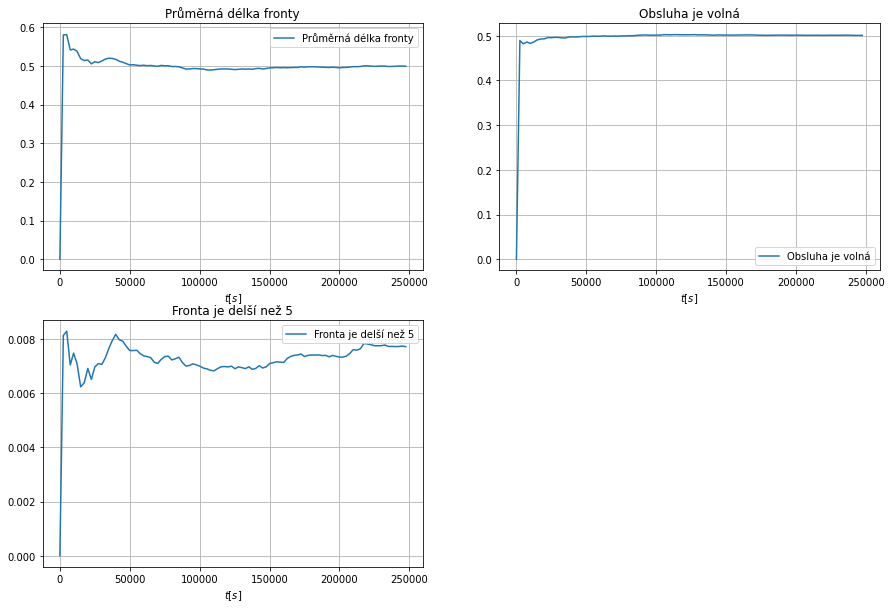

In [72]:
µ = 2
λ = 1
print('expected queue length', λ / µ)
if λ < µ:
  print('system is stable')
else:
  print('system is not stable')

#funkce pro generovani nahodnych cisel s exponencialnim rozdelenim
queueIntervalFunc = lambda : rndEx(random, λ)
#funkce pro generovani nahodnych cisel s exponencialnim rozdelenim
serviceIntervalFunc = lambda : rndEx(random, µ)

density = 10000
timeLine, resultsStore = runSim(queueIntervalFunc, serviceIntervalFunc, 100 * density, density)
plotResults(timeLine, resultsStore)

## Simulace netypického SHO
V dalším textu je simulován SHO, který není typu M/M/1. Jeho tok požadavků je určen jinou náhodnou veličinou, v tomto případě je konstantní s intervalem mezi požadavky 2s. Délka obsluhy je určena náhodnou veličinou s exponenciálním rozdělením.

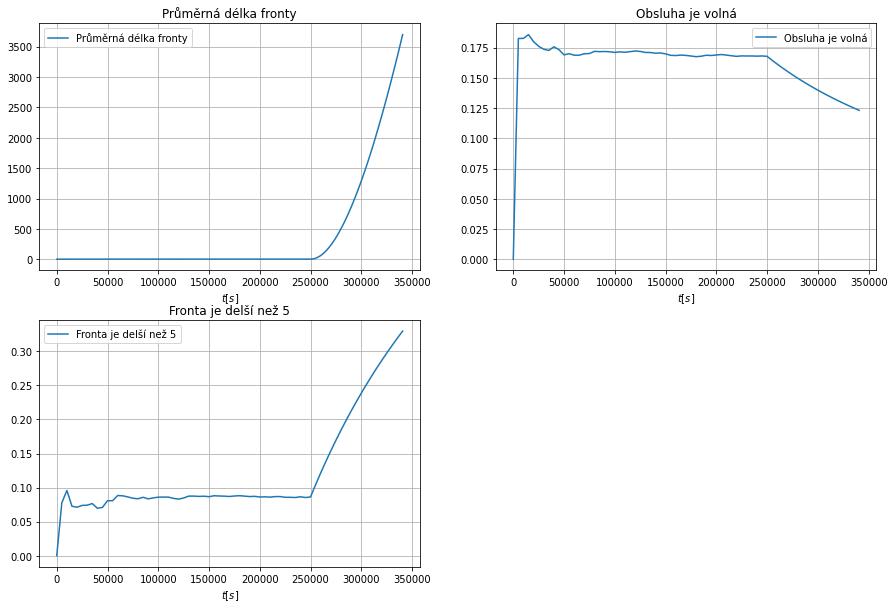

In [73]:
µ = 0.6
queueIntervalFunc = lambda : 2
#funkce pro generovani nahodnych cisel s exponencialnim rozdelenim
serviceIntervalFunc = lambda : rndEx(random, µ)

density = 10000
timeLine, resultsStore = runSim(queueIntervalFunc, serviceIntervalFunc, 100 * density, density)
plotResults(timeLine, resultsStore)